In [99]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


onwards_2016 = True

In [100]:
# Load the data
votes = pd.read_csv("../data/fulldata.csv")

votes["round"] = votes["round"].astype("category")

votes = votes[votes["distance"] > 0]
votes = votes[votes["round"] == "final"]


votes = votes[votes["from_country"] != votes["to_country"]] #exclude self-votes
votes = votes[votes["to_country"] != "au"] #exclude Australia
votes = votes[votes["from_country"] != "au"] #exclude Australia
if onwards_2016:
    votes = votes[votes["year"] >= 2016] #exclude years before 2016

length_before = len(votes)
print("Rows before dropping NA Collums:", length_before)
votes.columns
votes = votes.dropna(subset=["from_country", "to_country", "distance", "total_points"])
length_after = len(votes)

print("Dropped", length_before - length_after, "rows due to missing values")
length_before = length_after
print("Rows before dropping NA after forcing numeric:", length_before)
print(votes.columns)

Rows before dropping NA Collums: 6749
Dropped 0 rows due to missing values
Rows before dropping NA after forcing numeric: 6749
Index(['Unnamed: 0', 'year', 'round', 'from_country', 'to_country',
       'total_points', 'tele_points', 'jury_points', 'Year_from',
       'iso-alpha-3_from', 'chrstprotpct_from', 'chrstcatpct_from',
       'chrstorthpct_from', 'judgenpct_from', 'islmgenpct_from',
       'nonreligpct_from', 'StateAbb_from', 'city_from', 'lat_from',
       'lon_from', 'GDP per capita (current US$)_from',
       'Population, total_from', 'Year_to', 'iso-alpha-3_to',
       'chrstprotpct_to', 'chrstcatpct_to', 'chrstorthpct_to', 'judgenpct_to',
       'islmgenpct_to', 'nonreligpct_to', 'StateAbb_to', 'city_to', 'lat_to',
       'lon_to', 'GDP per capita (current US$)_to', 'Population, total_to',
       'distance', 'jaccard_artists', 'jaccard_genre', 'dice_genre',
       'dice_artists'],
      dtype='object')


/tmp/ipykernel_198674/3223605727.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv("../data/fulldata.csv")


In [101]:
votes
votes.replace("..",float("nan"),inplace=True)
print(votes['GDP per capita (current US$)_to'])

votes["GDP per capita (current US$)_from"] = pd.to_numeric(votes["GDP per capita (current US$)_from"], errors='coerce')
votes["GDP per capita (current US$)_to"] = pd.to_numeric(votes["GDP per capita (current US$)_to"], errors='coerce')
votes = votes.dropna(subset=["GDP per capita (current US$)_from", "GDP per capita (current US$)_to"])
length_after = len(votes)
print("Dropped", length_before - length_after, "rows due to missing values in GDP per capita")
print("Rows after dropping NA:", length_after)




36099     2158.461182
36101     8663.158203
36102     7570.931655
36103    51820.397248
36104    37024.215713
             ...     
47416    32610.110923
47417     8575.171134
47418    27331.209495
47419    12281.505849
47420    54343.226508
Name: GDP per capita (current US$)_to, Length: 6749, dtype: float64
Dropped 25 rows due to missing values in GDP per capita
Rows after dropping NA: 6724


/tmp/ipykernel_198674/930777973.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  votes.replace("..",float("nan"),inplace=True)


In [102]:
#Compute difference so that we can use that as varible in the regression

votes["GDP_Difference"] = votes["GDP per capita (current US$)_from"] - votes["GDP per capita (current US$)_to"]

if onwards_2016:
    # we know that this data is incomplete , so we will only look at newer data, where we have more complete data
    votes["Catholism_Difference"] = votes["chrstcatpct_from"] - votes["chrstcatpct_to"]

    votes["Protestant_Difference"] = votes["chrstprotpct_from"] - votes["chrstprotpct_to"]

    votes["Islam_Difference"] = votes["islmgenpct_from"] - votes["islmgenpct_to"]

    votes["Judaism_Difference"] = votes["judgenpct_from"] - votes["judgenpct_to"]

    length_before = len(votes)
    print("Rows before dropping NA Collums:", length_before)

    votes = votes.dropna(subset=["Catholism_Difference", "Protestant_Difference", "Islam_Difference", "Judaism_Difference"])
    length_after = len(votes)
    print("Dropped", length_before - length_after, "rows due to missing values in religion data")

Rows before dropping NA Collums: 6724
Dropped 398 rows due to missing values in religion data


In [103]:
votes.head

<bound method NDFrame.head of        Unnamed: 0  year  round from_country to_country  total_points  \
36099       36099  2016  final           al         ua             6   
36101       36101  2016  final           al         ru            14   
36102       36102  2016  final           al         bg            12   
36103       36103  2016  final           al         se             3   
36104       36104  2016  final           al         fr            10   
...           ...   ...    ...          ...        ...           ...   
47415       47415  2023  final           gb         ch             0   
47416       47416  2023  final           gb         si             1   
47417       47417  2023  final           gb         al             0   
47418       47418  2023  final           gb         pt             0   
47420       47420  2023  final           gb         de             0   

       tele_points  jury_points  Year_from iso-alpha-3_from  ...     distance  \
36099          6.0      

In [104]:
votes["distance"] = votes["distance"].astype("int")

#Normalize the data
votes["distance"] = (votes["distance"] - votes["distance"].mean()) / votes[
    "distance"
].std()
votes["GDP_Difference"] = (votes["GDP_Difference"] - votes["GDP_Difference"].mean()) / votes[
    "GDP_Difference"
].std()

if onwards_2016:
    votes["Catholism_Difference"] = (votes["Catholism_Difference"] - votes["Catholism_Difference"].mean()) / votes[
        "Catholism_Difference"
    ].std()
    votes["Protestant_Difference"] = (votes["Protestant_Difference"] - votes["Protestant_Difference"].mean()) / votes[
        "Protestant_Difference"
    ].std()
    votes["Islam_Difference"] = (votes["Islam_Difference"] - votes["Islam_Difference"].mean()) / votes[
        "Islam_Difference"
    ].std()
    votes["Judaism_Difference"] = (votes["Judaism_Difference"] - votes["Judaism_Difference"].mean()) / votes[
        "Judaism_Difference"
    ].std()


In [105]:
if onwards_2016:
    print("Running model with religion data")
    mixed_model = smf.mixedlm(
        formula="total_points ~ distance + GDP_Difference + Catholism_Difference + Protestant_Difference + Islam_Difference + Judaism_Difference",
        data=votes,
        groups=votes["from_country"],
    ).fit()
else:
    print("Running model without religion data")
    mixed_model = smf.mixedlm(
        formula="total_points ~ distance + GDP_Difference + year",
        re_formula='~distance', 
        data=votes,
        groups=votes["from_country"],
    ).fit()
    
print(mixed_model.summary())

Running model with religion data
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   total_points
No. Observations:   6326      Method:               REML        
No. Groups:         42        Scale:                32.3189     
Min. group size:    24        Log-Likelihood:       -19995.9222 
Max. group size:    168       Converged:            Yes         
Mean group size:    150.6                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              4.599    0.116 39.665 0.000  4.372  4.826
distance              -0.933    0.094 -9.902 0.000 -1.117 -0.748
GDP_Difference         0.419    0.139  3.017 0.003  0.147  0.692
Catholism_Difference   0.055    0.114  0.481 0.630 -0.168  0.278
Protestant_Difference -0.560    0.153 -3.650 0.000 -0.861 -0.259
Islam_

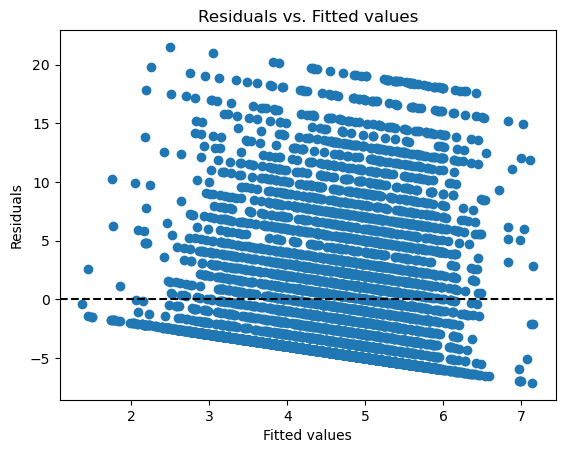

In [106]:
votes["residuals"] = mixed_model.resid
votes["fitted_values"] = mixed_model.fittedvalues

# Plot the residuals
plt.scatter(votes["fitted_values"], votes["residuals"])
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted values")
plt.axhline(y=0, color="black", linestyle="--")
plt.show()

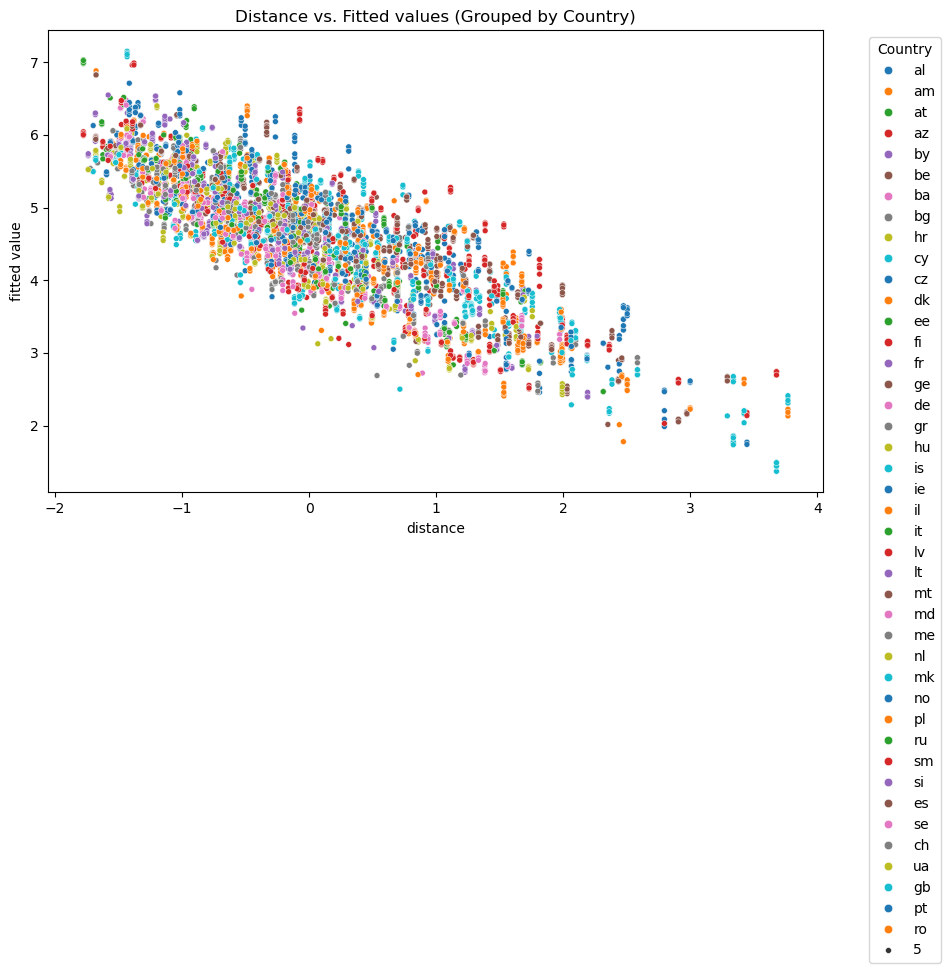

In [107]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="fitted_values", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10"  # Use a predefined palette
)
plt.xlabel("distance")
plt.ylabel("fitted value")
plt.title("Distance vs. Fitted values (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



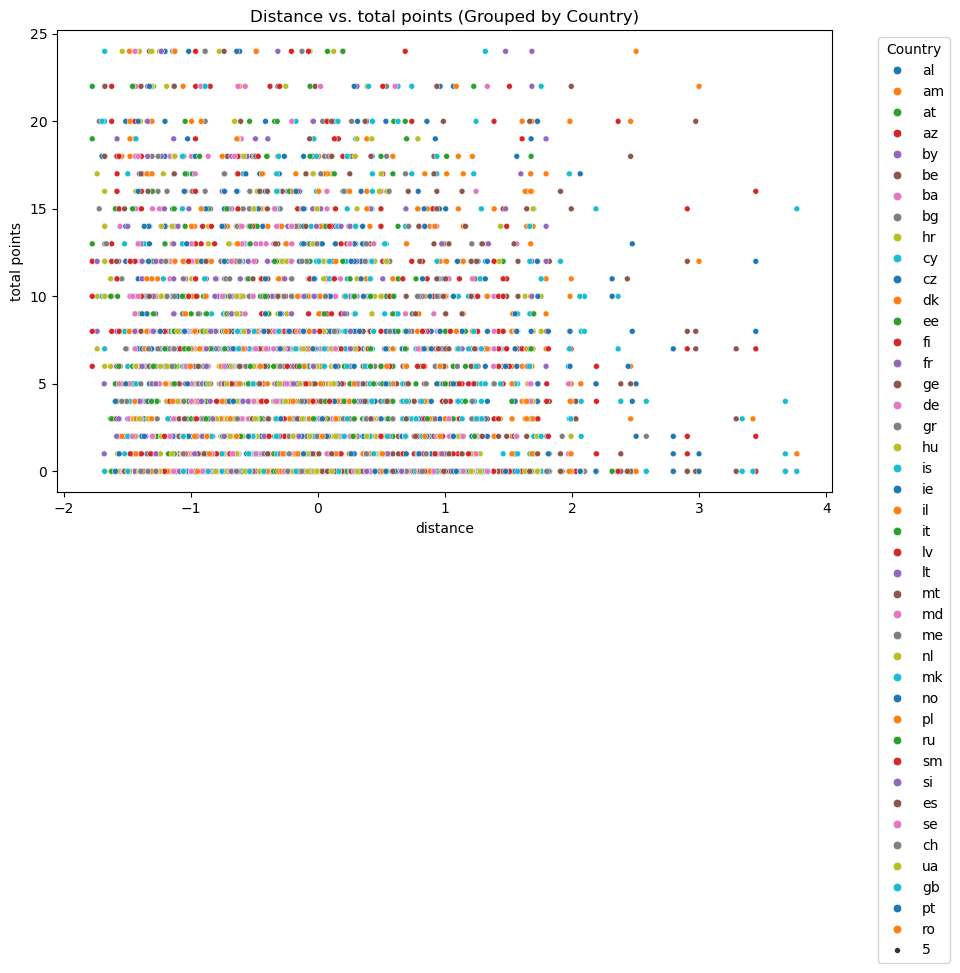

In [108]:
# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="total_points", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10"  # Use a predefined palette
)
plt.xlabel("distance")
plt.ylabel("total points")
plt.title("Distance vs. total points (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

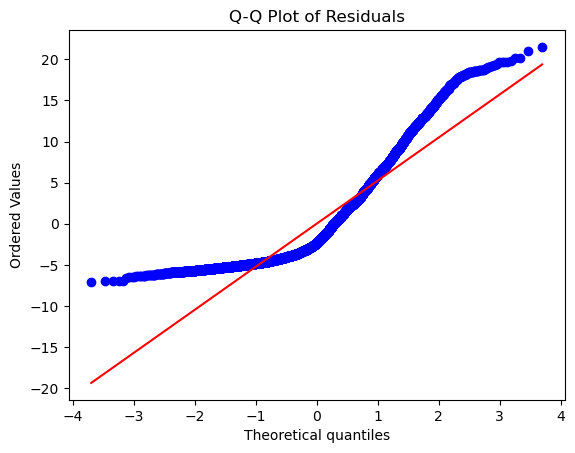

In [109]:
import scipy.stats as stats
# Assuming residuals are stored in votes["residuals"]
stats.probplot(votes["residuals"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()
